# Train model

In this model I train a model that classifies 7 guitar body types. Images are from Reverb.com and have been cleaned for duplicates as well as pictures that were zoomed in too much, or pictures of gigbacks, shop logo's, etc. FOr more details, check 'get_images.ipynb'.

First, importing the relevant packages and checking whether a GPU is available (recommended)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

torch.cuda.manual_seed_all(666)

CUDA is available!  Training on GPU ...


## Creating datasets

First I create training, validation and testing sets. 

In [2]:
from create_datasets import create_datasets

create_datasets('data', training_prop=0.7, validation_prop=0.2, test_prop=0.1)


jazzmaster: 3431
lespaul: 21928
mustang: 1922
prs_se: 13117
sg: 5093
stratocaster: 40238
telecaster: 21616
All files combined: 107345
jazzmaster train: 2401, validation: 686, test: 344
lespaul train: 15349, validation: 4385, test: 2194
mustang train: 1345, validation: 384, test: 193
prs_se train: 9181, validation: 2623, test: 1313
sg train: 3565, validation: 1018, test: 510
stratocaster train: 28166, validation: 8047, test: 4025
telecaster train: 15131, validation: 4323, test: 2162
Totals: train: 75138, validation 21466, test: 10741


## CNN from scratch

Below I am designing a CNN from scratch. The images are converted to greyscale because I think colours are not very important for classifying guitar types. 

In [2]:
data_dir = 'data'
batch_size = 10

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Grayscale(),
                                       transforms.Resize((128,128)),                                                              
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Grayscale(),
                                      transforms.Resize((128,128)),
                                      transforms.ToTensor()])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


classes = ['jazzmaster','lespaul', 'mustang', 'prs_se', 'SG','stratocaster','telecaster']
len_classes = len


Below some example images with the corresponding classes

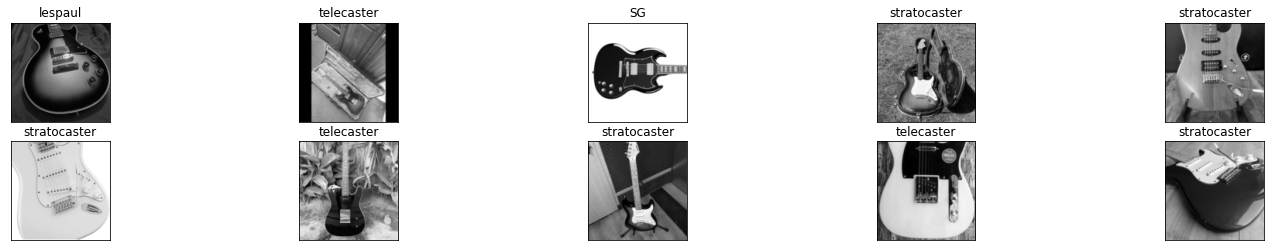

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(min(16,batch_size)):
    ax = fig.add_subplot(2, min(16,batch_size)/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(classes[labels[idx]])


Defining the CNN architecture

In [4]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 128x128x1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # convolutional layer (sees 64x64x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 32x32x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 16x16x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (128 * 8 * 8 -> 200)
        self.fc1 = nn.Linear(128 * 8 * 8, 200)
        # linear layer (200 -> 7)
        self.fc2 = nn.Linear(200, 7)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

Defining a function for training the model

In [6]:
def train_model(model, n_epochs, stop_at, stopping_criterion, model_path):

    epoch_count = []
    train_loss_list = []
    valid_loss_list = []

    valid_loss_min = np.Inf # track change in validation loss
    stopper = 0 # counter for epochs without improvement in validation data

    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0    
        valid_loss = 0.0
        class_correct = list(0. for i in range(len(classes)))
        class_total = list(0. for i in range(len(classes)))

        batch = 0

        ###################
        # train the model #
        ###################
        model.train()
            
        for data, target in train_loader:

            batch+=1

            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            # Print progress 
            print('\r Epoch: {} \t{:.2f}% completed'.format(epoch, batch/len(train_loader)*100), end='')
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(len(target.data)):
                if len(target.data)>1:
                    label = target.data[i]
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
            
        # print training/validation statistics 
        print('\n\t\tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            train_loss, valid_loss))
        print('\n\t\tValidation Accuracy (Overall): %2d%% (%2d/%2d)' % (
            100. * np.sum(class_correct) / np.sum(class_total),
            np.sum(class_correct), np.sum(class_total)))

        epoch_count.append(epoch)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
        # save model if validation loss has decreased
        if valid_loss_min - valid_loss > stopping_criterion :
            print('\t\tValidation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), model_path)
            valid_loss_min = valid_loss
            stopper = 0
        else:
            print('\t\tDecrease in validation loss less than {}'.format(stopping_criterion))
            stopper += 1
            if stopper==stop_at:
                break

        print('\n')
    
    # returns the data for the plot
    return epoch_count, train_loss_list, valid_loss_list

Train model

In [8]:
epoch_count, train_loss_list, valid_loss_list = train_model(model=model, n_epochs=50, stop_at=5, 
                                                            stopping_criterion=0.02, model_path='model.pt')

 Epoch: 1 	100.00% completed

NameError: name 'class_correct' is not defined

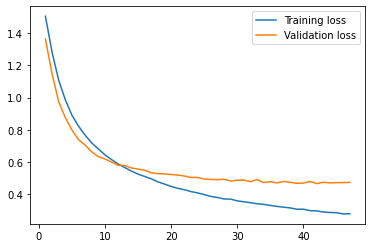

In [7]:
plt.plot(epoch_count, train_loss_list, label='Training loss')
plt.plot(epoch_count, valid_loss_list, label='Validation loss')
plt.legend()
plt.show()

In [8]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [9]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
# iterate over test data
for data, target in test_loader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        if len(target.data)>1:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.453736

Test Accuracy of jazzmaster: 64% (223/348)
Test Accuracy of lespaul: 88% (1957/2212)
Test Accuracy of mustang: 50% (98/196)
Test Accuracy of prs_se: 80% (1060/1317)
Test Accuracy of    SG: 50% (260/510)
Test Accuracy of stratocaster: 90% (3646/4025)
Test Accuracy of telecaster: 84% (1828/2162)

Test Accuracy (Overall): 84% (9072/10770)


In [2]:
data_dir = 'data'
batch_size = 40

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((224,224)),                                                              
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [3]:
vgg16 = models.vgg16(pretrained=True)

model = vgg16

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])

#Change the final parameter to 133 categories
model.classifier[0] = nn.Dropout(0.6, inplace=False)
model.classifier[1] = nn.Linear(in_features=25088, out_features=4096, bias=True)
model.classifier[2] = nn.ReLU(inplace=True)
model.classifier[3] = nn.Dropout(0.6, inplace=False)
model.classifier[4] = nn.Linear(in_features=4096, out_features=7, bias=True)
    
if train_on_gpu:
    model = model.cuda()

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [5]:
# maxium number of epochs to train the model
n_epochs = 50

epoch_count = []
train_loss_list = []
valid_loss_list = []

valid_loss_min = np.Inf # track change in validation loss
stopper = 0 # counter for epochs without improvement in validation data
stop_at = 5 # stops at 5 epochs without improvement in validation data

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0    
    valid_loss = 0.0
    batch = 0

    ###################
    # train the model #
    ###################
    model.train()
        
    for data, target in train_loader:

        batch+=1

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        # Print progress 
        print('\r Epoch: {} \t{:.2f}% completed'.format(epoch, batch/len(train_loader)*100), end='')
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('\n\t\tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
        train_loss, valid_loss))

    epoch_count.append(epoch)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_transfer.pt')
        valid_loss_min = valid_loss
        stopper = 0
    else:
        print('\t\tNo decrease in validation loss')
        stopper += 1
        if stopper==stop_at:
            break


 Epoch: 1 	100.00% completed
		Training Loss: 0.747 	Validation Loss: 0.467
		Validation loss decreased (inf --> 0.467).  Saving model ...
 Epoch: 2 	100.00% completed
		Training Loss: 0.501 	Validation Loss: 0.379
		Validation loss decreased (0.467 --> 0.379).  Saving model ...
 Epoch: 3 	100.00% completed
		Training Loss: 0.422 	Validation Loss: 0.353
		Validation loss decreased (0.379 --> 0.353).  Saving model ...
 Epoch: 4 	100.00% completed
		Training Loss: 0.369 	Validation Loss: 0.325
		Validation loss decreased (0.353 --> 0.325).  Saving model ...
 Epoch: 5 	100.00% completed
		Training Loss: 0.327 	Validation Loss: 0.301
		Validation loss decreased (0.325 --> 0.301).  Saving model ...
 Epoch: 6 	100.00% completed
		Training Loss: 0.294 	Validation Loss: 0.284
		Validation loss decreased (0.301 --> 0.284).  Saving model ...
 Epoch: 7 	100.00% completed
		Training Loss: 0.264 	Validation Loss: 0.278
		Validation loss decreased (0.284 --> 0.278).  Saving model ...
 Epoch: 8 	100.

KeyboardInterrupt: 

In [6]:
classes = ['jazzmaster','lespaul', 'mustang', 'prs_se', 'SG','stratocaster','telecaster']
len_classes = len


# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

model.eval()
# iterate over test data
for data, target in test_loader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        if len(target.data)>1:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.261589

Test Accuracy of jazzmaster: 77% (268/348)
Test Accuracy of lespaul: 93% (2064/2212)
Test Accuracy of mustang: 69% (136/196)
Test Accuracy of prs_se: 90% (1199/1318)
Test Accuracy of    SG: 75% (383/510)
Test Accuracy of stratocaster: 96% (3876/4025)
Test Accuracy of telecaster: 88% (1904/2162)

Test Accuracy (Overall): 91% (9830/10771)
